<a href="https://colab.research.google.com/github/Witold21/WDN/blob/main/Iteracja_zawor%C3%B3wLeak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install epyt pymoo
%pip install numpy==1.23
!git clone https://github.com/Witold21/WDN.git
import os
os.chdir('/content/WDN/EPYT')
!ls

fatal: destination path 'WDN' already exists and is not an empty directory.
 epyt_epanet_analysis.ipynb	   epyt_leakage_simulation_and_detection.ipynb	 Walkerton_v1.inp
'epy testy.ipynb'		   epyt_pressure_sensor_placement.ipynb
 epytflow_leakagedetection.ipynb   REQUIREMENTS.txt


In [2]:
from epyt import epanet
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math

In [3]:
d=epanet('Walkerton_v1.inp')

EPANET version 20200 loaded (EPyT version v1.2.0 - Last Update: 01/08/2024).
Input File Walkerton_v1.inp loaded successfully.



In [4]:
import warnings
# Ignorowanie ostrzeżeń użytkownika (warnings)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
d.setTimeSimulationDuration(2 * 24 * 60 * 60)  # greater weight to low demand hours
d.setTimePatternStart(0)  # in seconds

In [6]:
allleaknodes = ['J155' , 'J236', 'J189', 'J85']
num_valves  = 10
restricted_pipes= [359,360,361, 363,349,354]

In [7]:
all_links = d.getLinkIndex()
all_nodes = d.getNodeIndex()
#all_links = [124, 156, 278, 78, 142, 121, 237, 60, 59, 11, 112, 244, 34, 254, 301, 98, 17, 56, 346, 19, 237, 87, 296, 236, 111, 286, 236, 287, 266, 146, 237, 139, 57, 264,226, 208, 170, 133, 35, 264, 9, 9, 113, 221, 170, 294, 258, 54, 338, 153,198, 80, 266, 317, 289, 323, 87, 186, 227, 289]

In [8]:
def DaneZSymulacji():
      data = d.getComputedHydraulicTimeSeries(['Time', 'Pressure'])
      time = data.Time
      pressure = data.Pressure
      pressure = np.mean(pressure, axis=1)
      pressure = pressure[:, np.newaxis]
      pressure = pressure.ravel()
      pressure_time = np.column_stack((time, pressure))
      return pressure_time

In [9]:
def WspolnyCzas(presTime1, pressTime2):
    common_times = np.intersect1d(presTime1[:, 0], pressTime2[:, 0])
    filtered_no_leak = np.array([row for row in presTime1 if row[0] in common_times])
    filtered_leak = np.array([row for row in pressTime2 if row[0] in common_times])
    return filtered_no_leak, filtered_leak

In [10]:
def OdlegloscEuklidesa(pressure_time1, pressure_time2):
    squared_differences = [
        (row1[1] - row2[1]) ** 2
        for row1, row2 in zip(pressure_time1, pressure_time2)]
    sum_squared_differences = sum(squared_differences)
    wskaznik = math.sqrt(sum_squared_differences)
    return wskaznik

In [11]:
def WykresZaworu(pressure_time1, pressure_time2, pressure_time3):
    x_leak_pipe = [row[0] for row in pressure_time1]
    y_leak_pipe = [row[1] for row in pressure_time1]

    x_no_leak = [row[0] for row in pressure_time2]
    y_no_leak = [row[1] for row in pressure_time2]

    x_leak = [row[0] for row in pressure_time3]
    y_leak = [row[1] for row in pressure_time3]

    plt.figure(figsize=(12, 6))
    plt.plot(x_leak_pipe, y_leak_pipe, label='Ciśnienie z wyciekiem i zaworem', color='blue', linestyle='-', marker='o')
    plt.plot(x_no_leak, y_no_leak, label='Ciśnienie bez wycieku', color='red', linestyle='-', marker='x')
    plt.plot(x_leak, y_leak, label='Ciśnienie z wyciekem', color='green', linestyle='-', marker='x')

    plt.title('Ciśnienie w czasie (z wyciekiem vs bez wycieku)')
    plt.xlabel('Czas [s]')
    plt.ylabel('Ciśnienie [jednostka]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
def WykresResiduum(pressure_time1, pressure_time2, pressure_time3):
    # Wyciąganie danych
    x_leak_pipe = [row[0] for row in pressure_time1]
    y_leak_pipe = [row[1] for row in pressure_time1]

    x_no_leak = [row[0] for row in pressure_time2]
    y_no_leak = [row[1] for row in pressure_time2]

    x_leak = [row[0] for row in pressure_time3]
    y_leak = [row[1] for row in pressure_time3]

    # Obliczanie różnic ciśnień
    diff_leak_pipe_no_leak = [abs(y1 - y2) for y1, y2 in zip(y_leak_pipe, y_no_leak)]
    diff_leak_no_leak = [abs(y1 - y2) for y1, y2 in zip(y_leak, y_no_leak)]
    plt.figure(figsize=(12, 6))
    # Wykres różnicy: Z wyciekiem i zaworem - Bez wycieku
    plt.plot(x_leak_pipe, diff_leak_pipe_no_leak, label='Różnica: Z wyciekiem i zaworem - Bez wycieku', color='blue', linestyle='-', marker='o')

    # Wykres różnicy: Z wyciekiem - Bez wycieku
    plt.plot(x_leak, diff_leak_no_leak, label='Różnica: Z wyciekiem - Bez wycieku', color='green', linestyle='-', marker='x')

    # Dodatkowe ustawienia wykresu
    plt.title('Różnice ciśnienia w czasie')
    plt.xlabel('Czas [s]')
    plt.ylabel('Różnica ciśnienia [jednostka]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
pressure_time_no_leak = DaneZSymulacji()

wskaznik dla wycieku bez zaworów: 14.590735868671725

Placing valve 1...
wskaznik_best: 14.590735868671725

pipe: 1
wskaznik: 14.590939389344287

pipe: 2
wskaznik: 14.59071057731356
Pick_me_pipe: 2

pipe: 3
wskaznik: 18.203010984987255

pipe: 4
wskaznik: 16743676.469522573

pipe: 5
wskaznik: 14.917215072053947

pipe: 6
wskaznik: 14.91560508427195

pipe: 7
wskaznik: 14.913009734159205

pipe: 8
wskaznik: 14.63497436566594

pipe: 9
wskaznik: 15.144435265951516

pipe: 10
wskaznik: 14.995120708884516

pipe: 11
wskaznik: 15.125708157839753

pipe: 12
wskaznik: 14.57129523348299
Pick_me_pipe: 12

pipe: 13
wskaznik: 14.931796663227262

pipe: 14
wskaznik: 14.90453066522504

pipe: 15
wskaznik: 18.909786843184598

pipe: 16
wskaznik: 19.77779851922822

pipe: 17
wskaznik: 14.598147442029756

pipe: 18
wskaznik: 1366617.6935469855

pipe: 19
wskaznik: 15.048910221354838

pipe: 20
wskaznik: 15.063915225289804

pipe: 21
wskaznik: 15.097468552634908

pipe: 22
wskaznik: 15.090674744677969

pipe: 23
wskazni

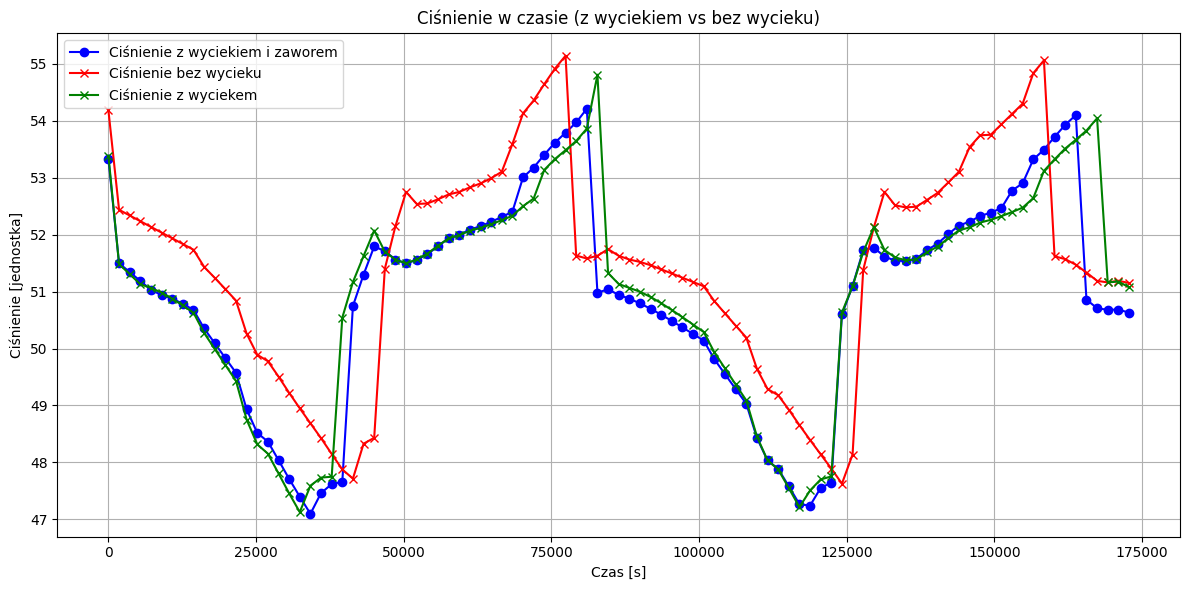

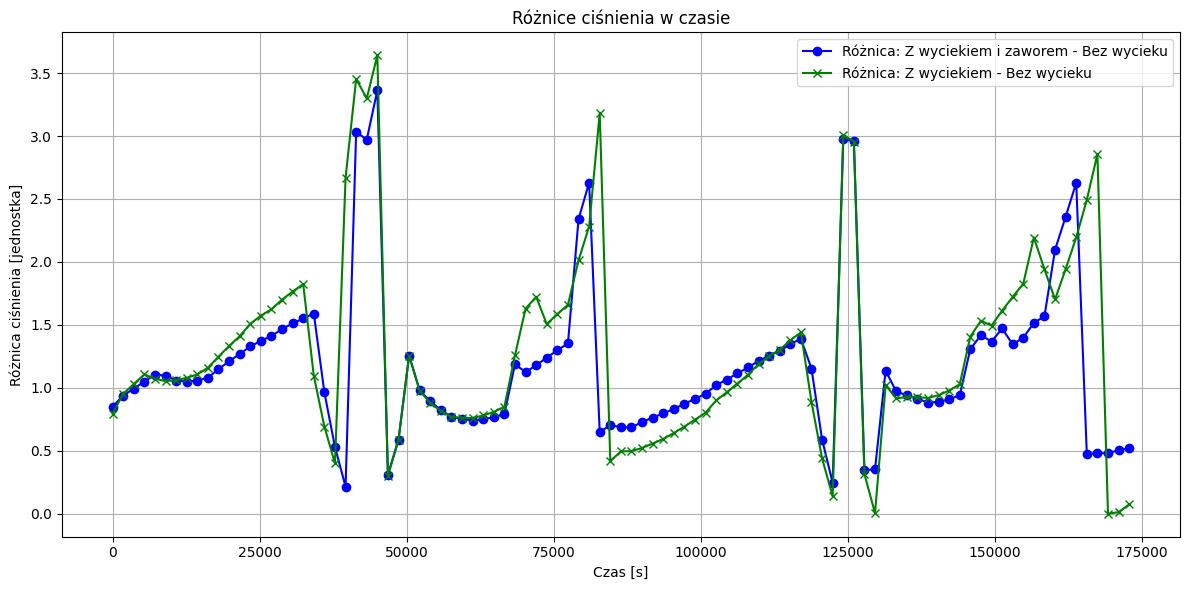

[210]

Placing valve 2...
wskaznik_best: 13.093008425382418

pipe: 1
wskaznik: 13.093001921769742
Pick_me_pipe: 1

pipe: 2
wskaznik: 13.093426582687968

pipe: 3
wskaznik: 17.394798464891835

pipe: 4
wskaznik: 16750623.513861937

pipe: 5
wskaznik: 13.540569570222331

pipe: 6
wskaznik: 13.567698561241198

pipe: 7
wskaznik: 13.564471178593644

pipe: 8
wskaznik: 13.178475649508217

pipe: 9
wskaznik: 13.119928847125582

pipe: 10
wskaznik: 13.40536097935863

pipe: 11
wskaznik: 13.065811661790967
Pick_me_pipe: 11

pipe: 12
wskaznik: 13.089570805442905

pipe: 13
wskaznik: 13.296370184677714

pipe: 14
wskaznik: 13.365262684761257

pipe: 15
wskaznik: 18.424168039367053

pipe: 16
wskaznik: 19.54631416477608

pipe: 17
wskaznik: 13.357446515931592

pipe: 18
wskaznik: 1366618.1533068076

pipe: 19
wskaznik: 13.289583805945439

pipe: 20
wskaznik: 13.274344001090713

pipe: 21
wskaznik: 13.260807187082227

pipe: 22
wskaznik: 13.249610177674096

pipe: 23
wskaznik: 13.242354787976979

pipe: 24
wskaznik: 1

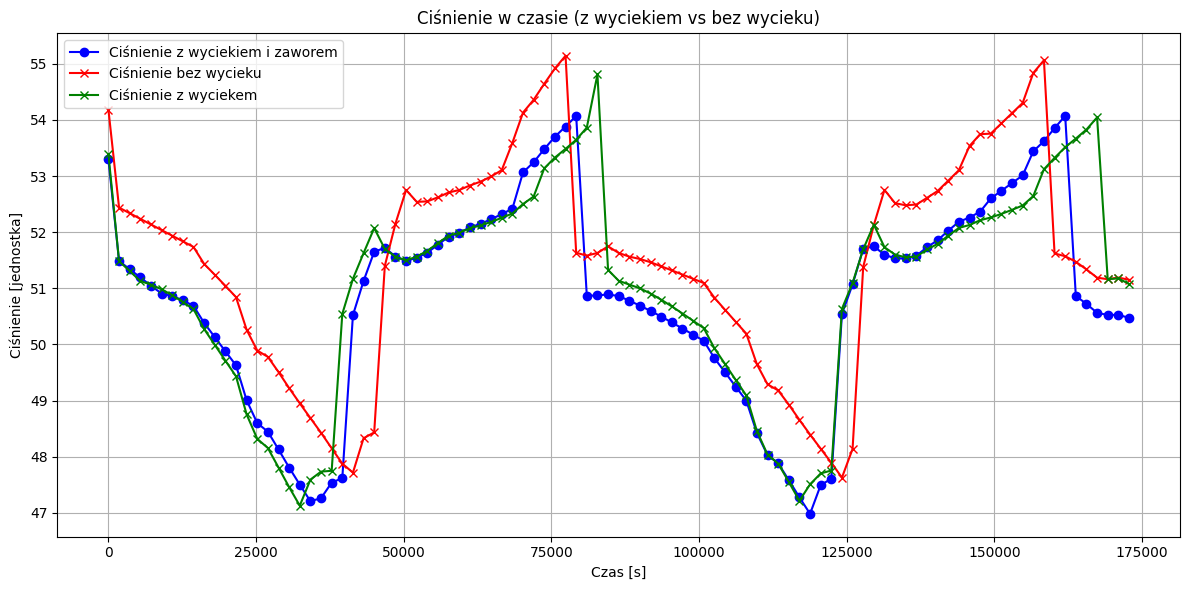

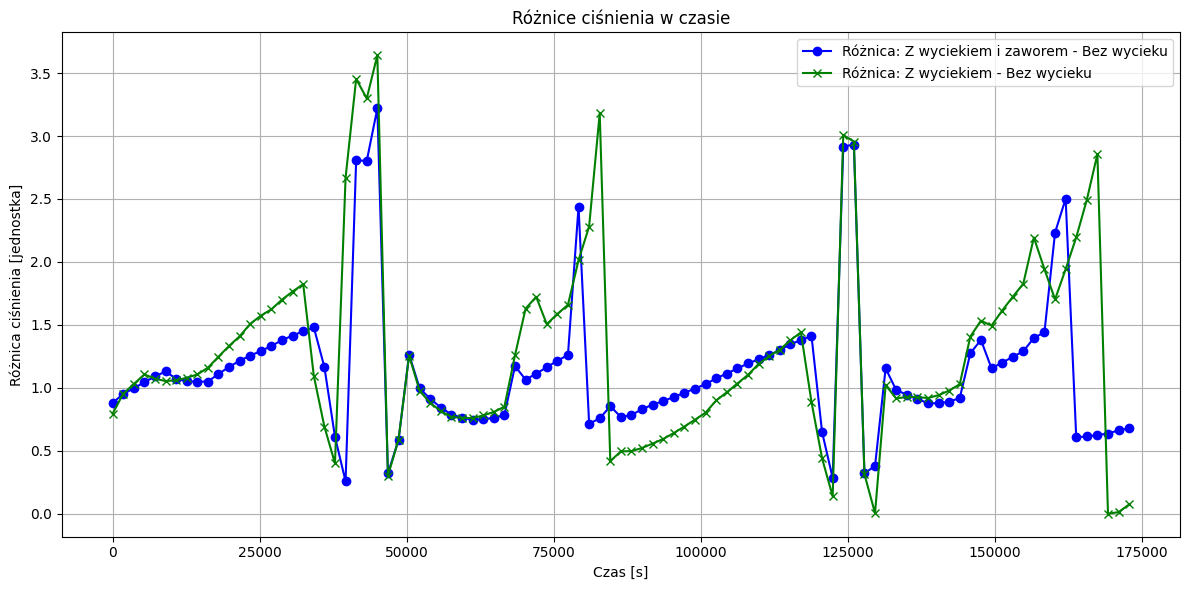

[210, 155]

Placing valve 3...
wskaznik_best: 12.458365610747045

pipe: 1
wskaznik: 12.458378353797158

pipe: 2
wskaznik: 12.458370960220414

pipe: 3
wskaznik: 17.241729803954296

pipe: 4
wskaznik: 16747340.771902993

pipe: 5
wskaznik: 12.984146519287433

pipe: 6
wskaznik: 12.980943484373094

pipe: 7
wskaznik: 12.976060549433717

pipe: 8
wskaznik: 12.502530802299024

pipe: 9
wskaznik: 12.491140149594361

pipe: 10
wskaznik: 12.164495277333586
Pick_me_pipe: 10

pipe: 11
wskaznik: 12.412789379309574

pipe: 12
wskaznik: 12.420514131373157

pipe: 13
wskaznik: 12.657919349431934

pipe: 14
wskaznik: 13.408630942181599

pipe: 15
wskaznik: 18.4364854706224

pipe: 16
wskaznik: 19.37663641195783

pipe: 17
wskaznik: 12.679918227088297

pipe: 18
wskaznik: 1366618.624758552

pipe: 19
wskaznik: 12.374561148969331

pipe: 20
wskaznik: 12.366109769534903

pipe: 21
wskaznik: 12.671519345787605

pipe: 22
wskaznik: 12.657712312242923

pipe: 23
wskaznik: 12.644572071861079

pipe: 24
wskaznik: 12.63348892301

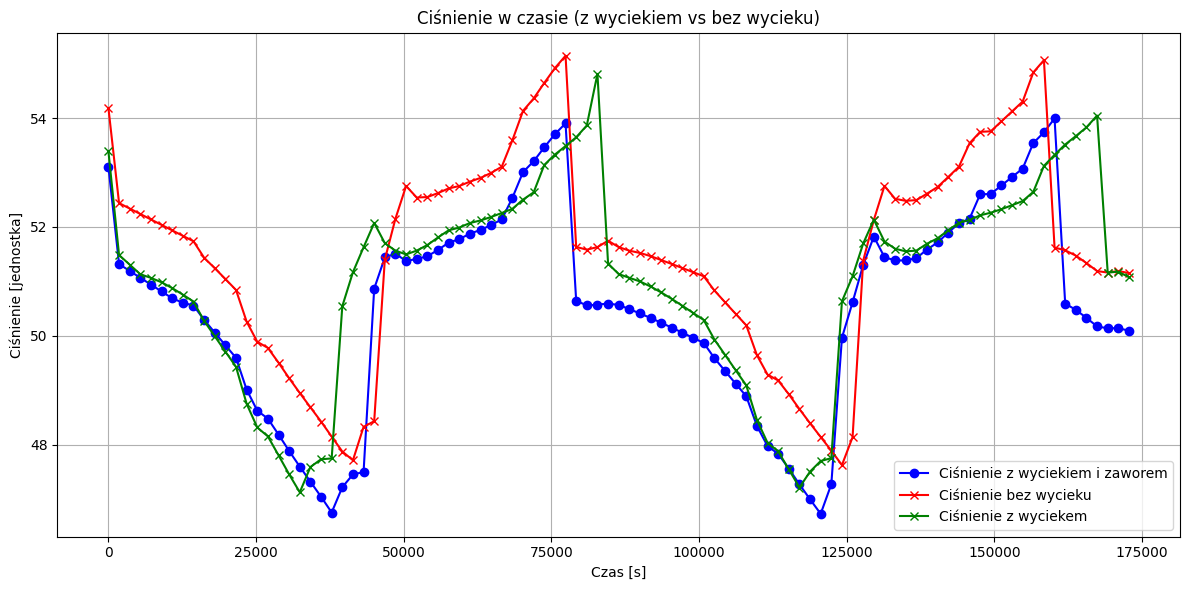

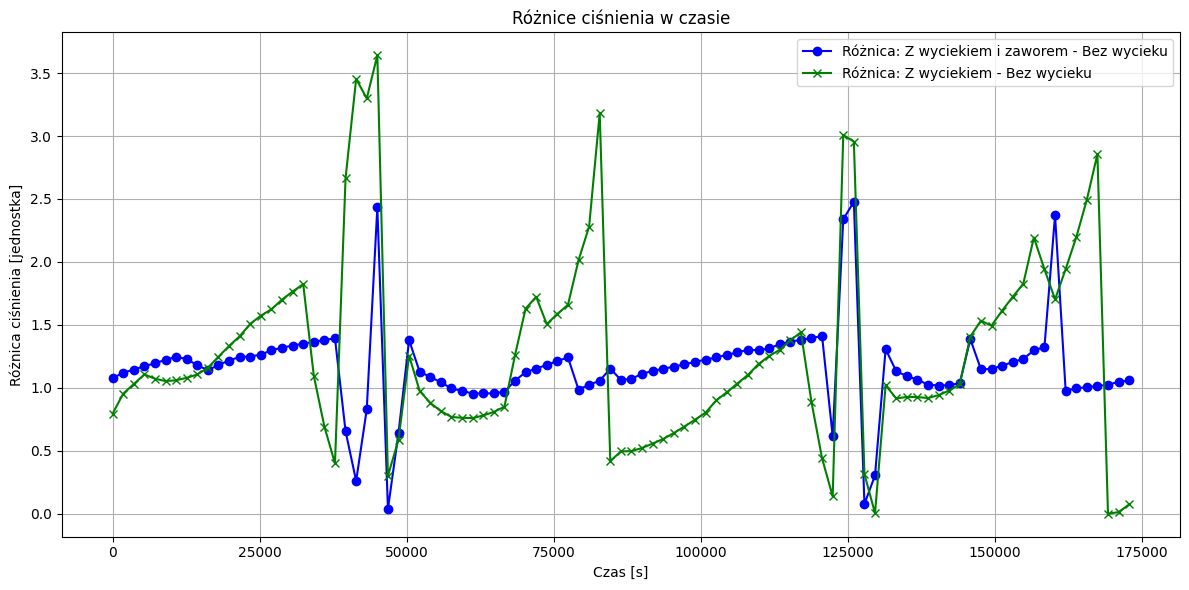

[210, 155, 124]

Placing valve 4...
wskaznik_best: 11.979396992159957

pipe: 1
wskaznik: 11.979342414273251
Pick_me_pipe: 1

pipe: 2
wskaznik: 11.97935934835126

pipe: 3
wskaznik: 17.370848037103997

pipe: 4
wskaznik: 16752383.154661547

pipe: 5
wskaznik: 12.143930786557881

pipe: 6
wskaznik: 12.167451181465644

pipe: 7
wskaznik: 12.15871636554335

pipe: 8
wskaznik: 12.121588600104953

pipe: 9
wskaznik: 11.963746788817607
Pick_me_pipe: 9

pipe: 10
wskaznik: 12.167544493647132

pipe: 11
wskaznik: 11.88460582912879
Pick_me_pipe: 11

pipe: 12
wskaznik: 11.905937535727013

pipe: 13
wskaznik: 34.852711894803704

pipe: 14
wskaznik: 35.67188565188011

pipe: 15
wskaznik: 18.22154569109446

pipe: 16
wskaznik: 21.9729914813395

pipe: 17
wskaznik: 12.286576458404536

pipe: 18
wskaznik: 1366620.6897456073

pipe: 19
wskaznik: 12.197931149175545

pipe: 20
wskaznik: 12.168360500748022

pipe: 21
wskaznik: 12.14207263671164

pipe: 22
wskaznik: 12.120253145770604

pipe: 23
wskaznik: 11.857539600592757
P

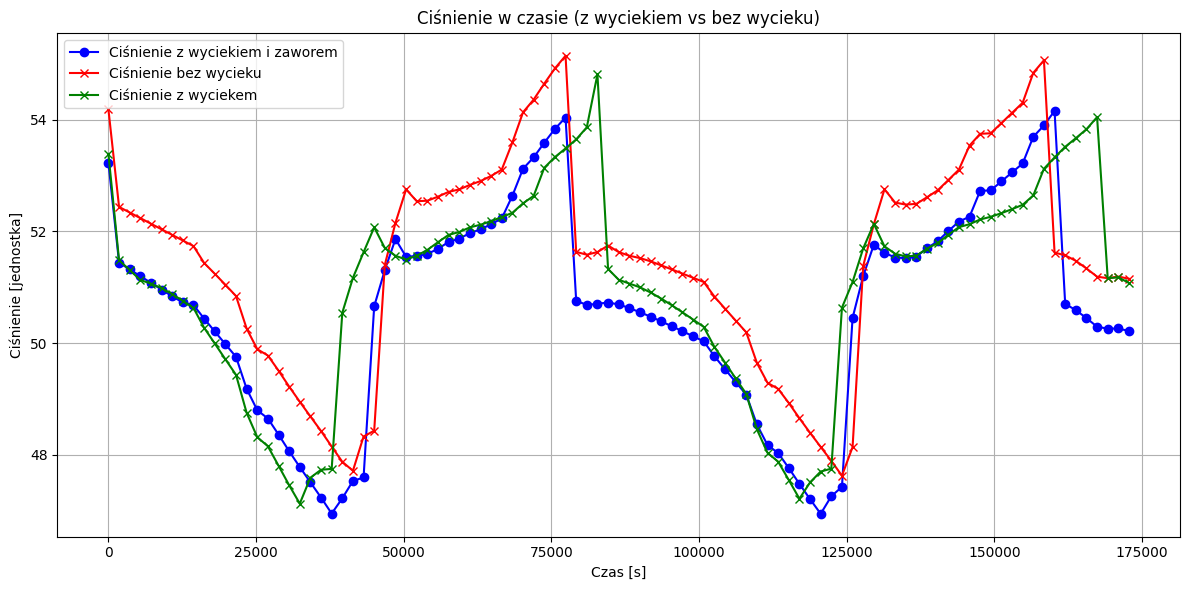

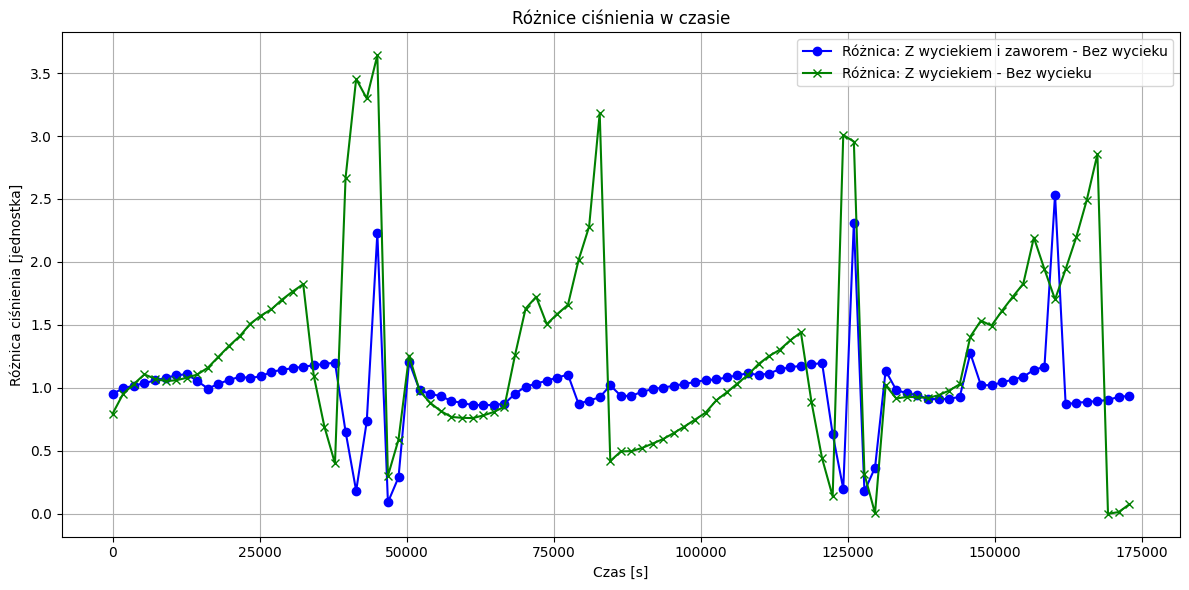

[210, 155, 124, 146]

Placing valve 5...
wskaznik_best: 10.457176873656518

pipe: 1
wskaznik: 10.458129942160376

pipe: 2
wskaznik: 10.457135429610096
Pick_me_pipe: 2

pipe: 3
wskaznik: 16.544061958067243

pipe: 4
wskaznik: 16748025.290347567

pipe: 5
wskaznik: 10.954317938150103

pipe: 6
wskaznik: 10.951025148329974

pipe: 7
wskaznik: 10.97036353927453

pipe: 8
wskaznik: 10.520838333850119

pipe: 9
wskaznik: 10.788743332615487

pipe: 10
wskaznik: 10.674892185236983

pipe: 11
wskaznik: 10.555431058507596

pipe: 12
wskaznik: 10.71490083673157

pipe: 13
wskaznik: 34.03433190197815

pipe: 14
wskaznik: 34.46872410018667

pipe: 15
wskaznik: 17.574020999715657

pipe: 16
wskaznik: 27.08651325683195

pipe: 17
wskaznik: 10.74491657598889

pipe: 18
wskaznik: 1366619.9576115755

pipe: 19
wskaznik: 10.864696608132904

pipe: 20
wskaznik: 10.974456287721775

pipe: 21
wskaznik: 10.94391408328295

pipe: 22
wskaznik: 10.889959686672782

pipe: 23
wskaznik: 10.86734930363598

pipe: 24
wskaznik: 10.579047

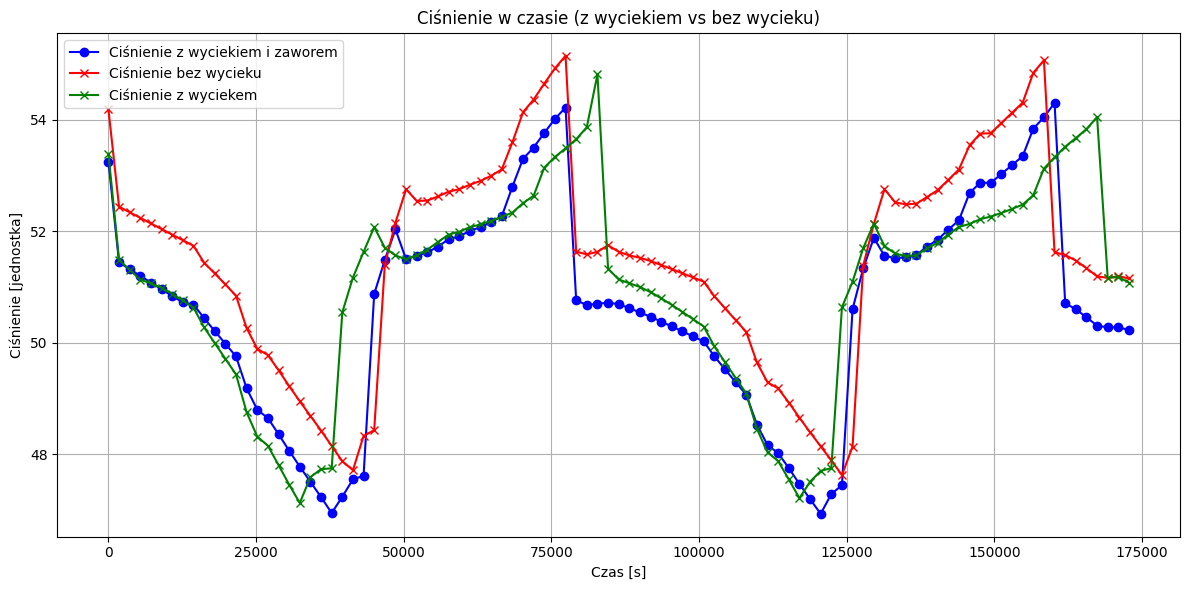

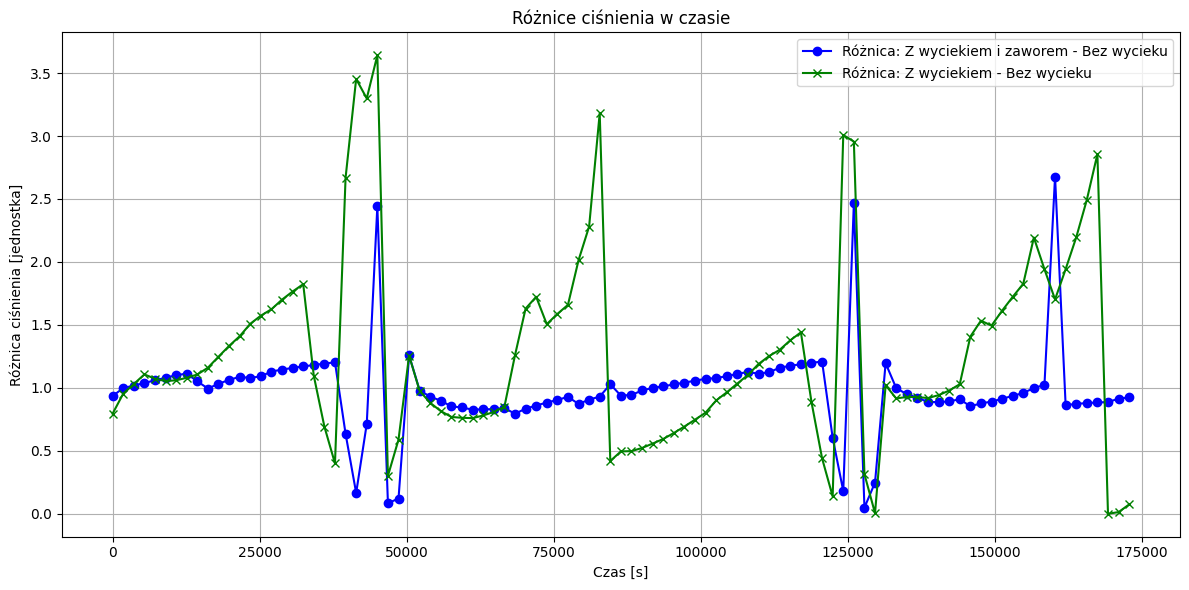

[210, 155, 124, 146, 278]

Placing valve 6...
wskaznik_best: 10.330655162334798

pipe: 1
wskaznik: 10.330664499207577

pipe: 2
wskaznik: 10.33064923018428
Pick_me_pipe: 2

pipe: 3
wskaznik: 16.453258707076518

pipe: 4
wskaznik: 16750427.126985075

pipe: 5
wskaznik: 11.231173405240208

pipe: 6
wskaznik: 11.226548685353828

pipe: 7
wskaznik: 11.217970534904522

pipe: 8
wskaznik: 10.429715156864452

pipe: 9
wskaznik: 10.823650576021612

pipe: 10
wskaznik: 10.6721301376664

pipe: 11
wskaznik: 10.799021176536355

pipe: 12
wskaznik: 10.636014390434262

pipe: 13
wskaznik: 34.310457834644474

pipe: 14
wskaznik: 34.871213936913314

pipe: 15
wskaznik: 17.853182107318332

pipe: 16
wskaznik: 18.160580247234602

pipe: 17
wskaznik: 11.314587410925451

pipe: 18
wskaznik: 1366619.6062807215

pipe: 19
wskaznik: 11.285997359825672

pipe: 20
wskaznik: 11.25122915271187

pipe: 21
wskaznik: 11.18800195456444

pipe: 22
wskaznik: 10.841125139480091

pipe: 23
wskaznik: 10.81267334009499

pipe: 24
wskaznik: 10

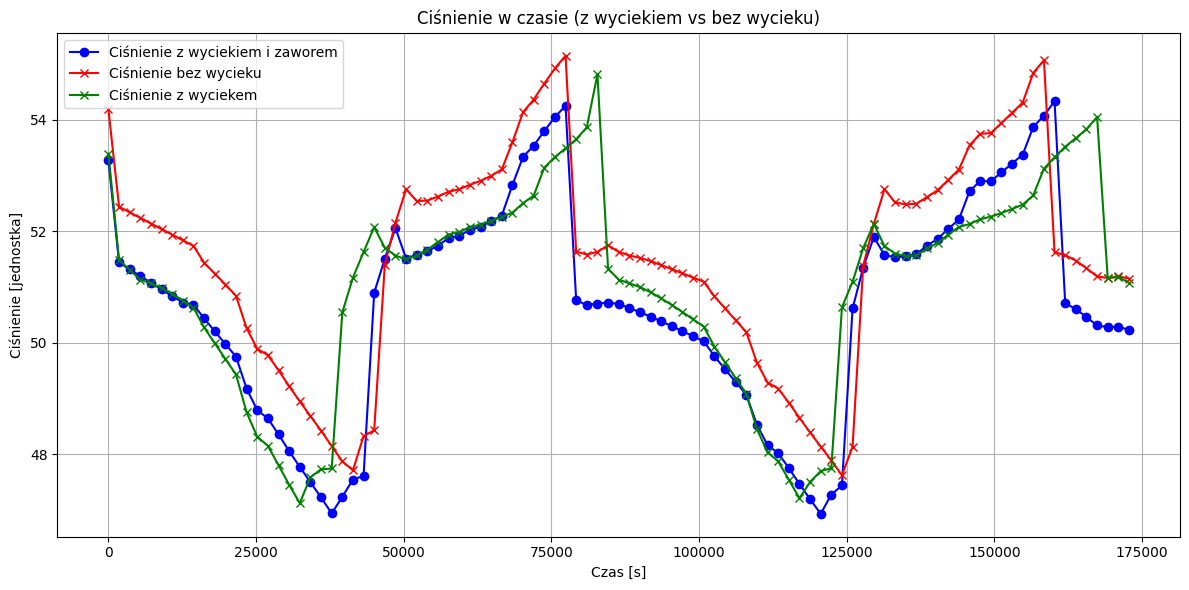

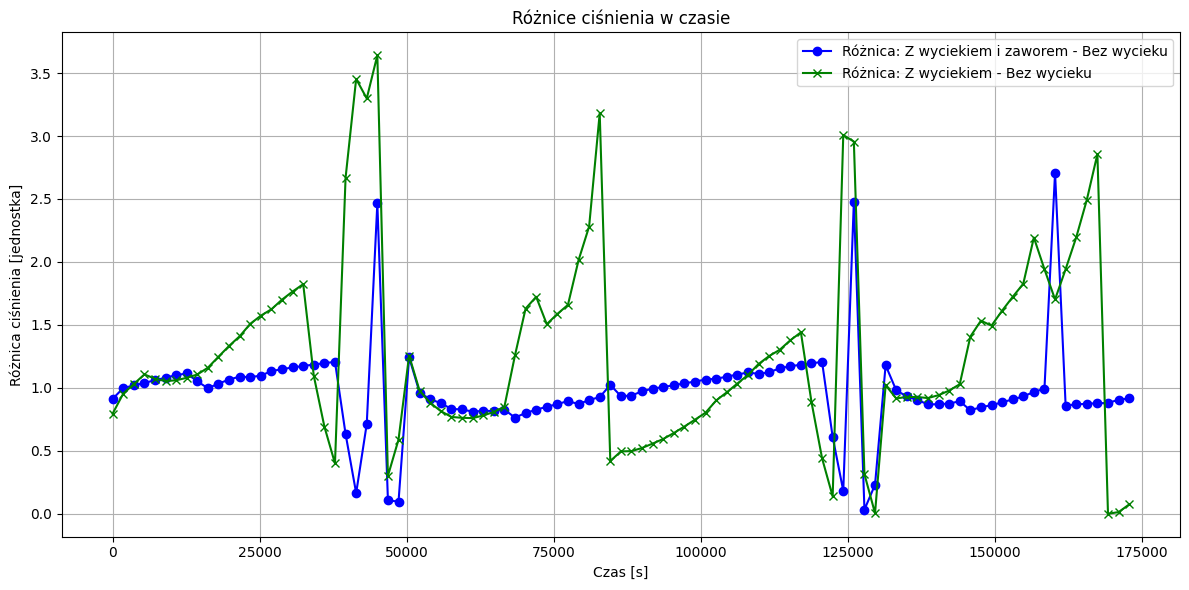

[210, 155, 124, 146, 278, 217]

Placing valve 7...
wskaznik_best: 10.271724627553063

pipe: 1
wskaznik: 10.271844823929984

pipe: 2
wskaznik: 10.271714801671122
Pick_me_pipe: 2

pipe: 3
wskaznik: 16.444526479323986

pipe: 4
wskaznik: 16743479.399637692

pipe: 5
wskaznik: 11.199554890783494

pipe: 6
wskaznik: 11.269471410462337

pipe: 7
wskaznik: 11.260478417096683

pipe: 8
wskaznik: 10.418059994500439

pipe: 9
wskaznik: 10.835679980739313

pipe: 10
wskaznik: 10.727572953792812

pipe: 11
wskaznik: 10.79621380823254

pipe: 12
wskaznik: 10.585466517252435

pipe: 13
wskaznik: 34.338432705962006

pipe: 14
wskaznik: 34.90358462056508

pipe: 15
wskaznik: 17.792545910739186

pipe: 16
wskaznik: 18.338743146153046

pipe: 17
wskaznik: 11.29945645221051

pipe: 18
wskaznik: 1366619.5282513383

pipe: 19
wskaznik: 11.263838654175801

pipe: 20
wskaznik: 11.228709855829763

pipe: 21
wskaznik: 11.163919588807317

pipe: 22
wskaznik: 11.069580927292195

pipe: 23
wskaznik: 10.781821610954315

pipe: 24
wska

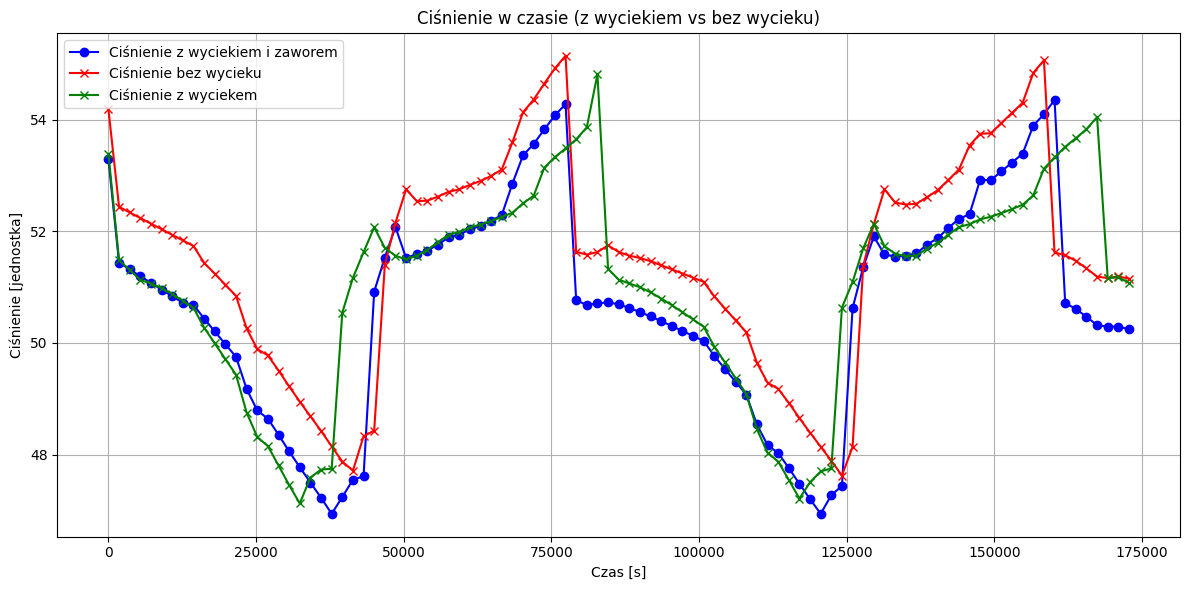

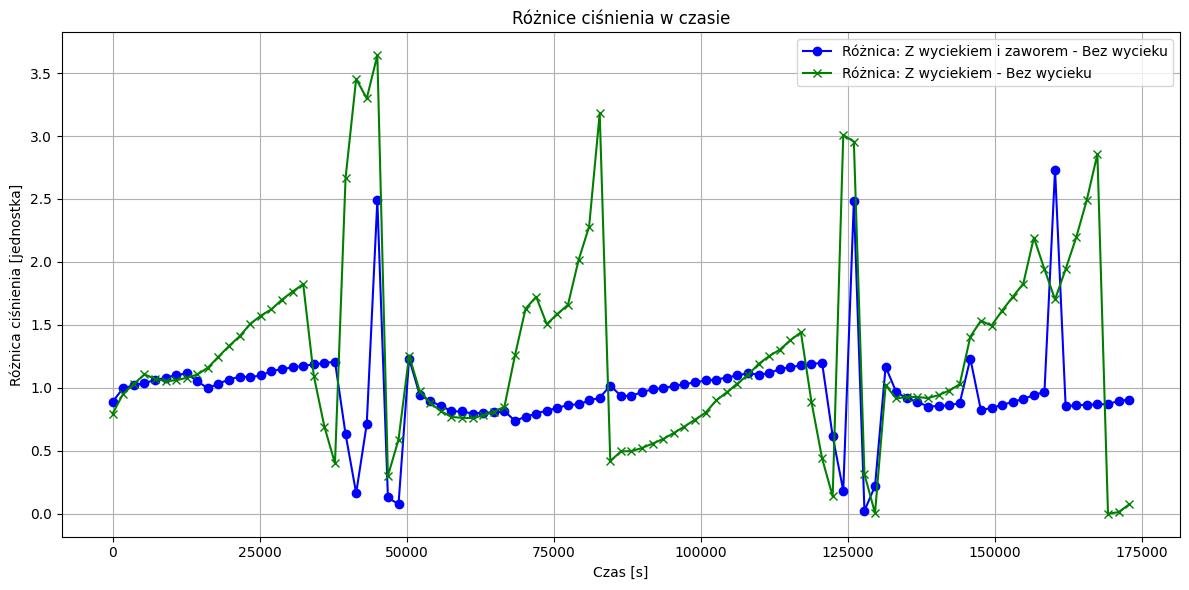

[210, 155, 124, 146, 278, 217, 143]

Placing valve 8...
wskaznik_best: 10.255707526758773

pipe: 1
wskaznik: 10.255681707080482
Pick_me_pipe: 1

pipe: 2
wskaznik: 10.255683386578585

pipe: 3
wskaznik: 16.363508384034652

pipe: 4
wskaznik: 16752899.194822768

pipe: 5
wskaznik: 11.285153057120365

pipe: 6
wskaznik: 11.281376589029325

pipe: 7
wskaznik: 11.27280131336178

pipe: 8
wskaznik: 10.36099719811198

pipe: 9
wskaznik: 10.783580624825364

pipe: 10
wskaznik: 11.00807266385415

pipe: 11
wskaznik: 10.739219606633485

pipe: 12
wskaznik: 10.576087380629112

pipe: 13
wskaznik: 34.363477274977825

pipe: 14
wskaznik: 34.93362958885638

pipe: 15
wskaznik: 17.724312333503324

pipe: 16
wskaznik: 18.533236836447678

pipe: 17
wskaznik: 11.249679351700372

pipe: 18
wskaznik: 1366619.4952289297

pipe: 19
wskaznik: 11.215413547460306

pipe: 20
wskaznik: 11.179985162696129

pipe: 21
wskaznik: 11.147834623774227

pipe: 22
wskaznik: 11.088273720593001

pipe: 23
wskaznik: 10.725983323929512

pipe: 24


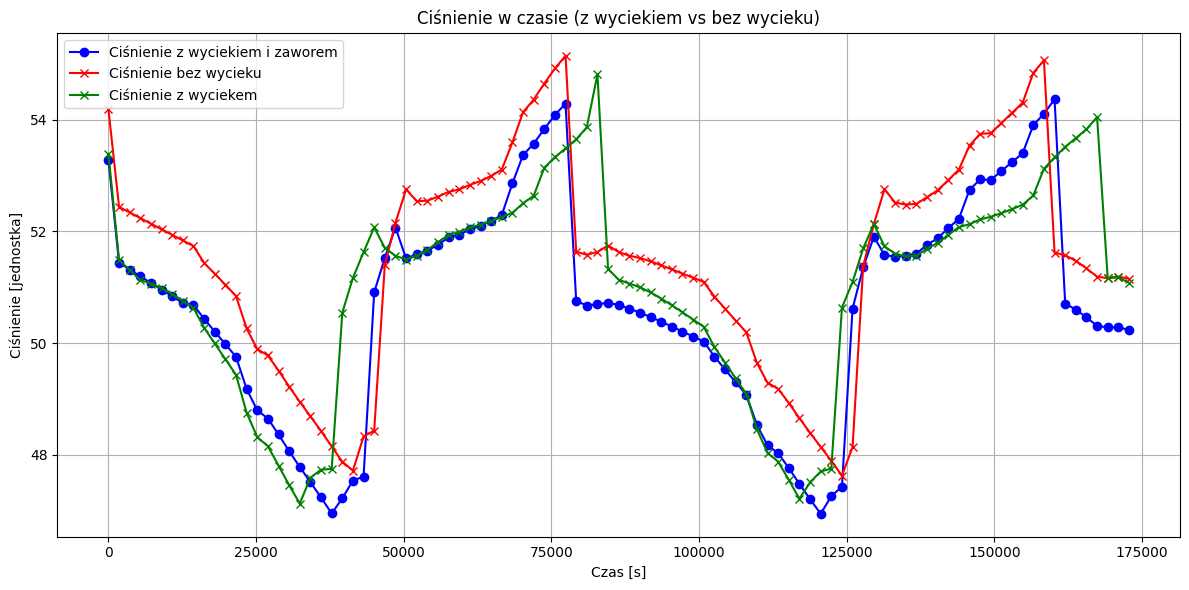

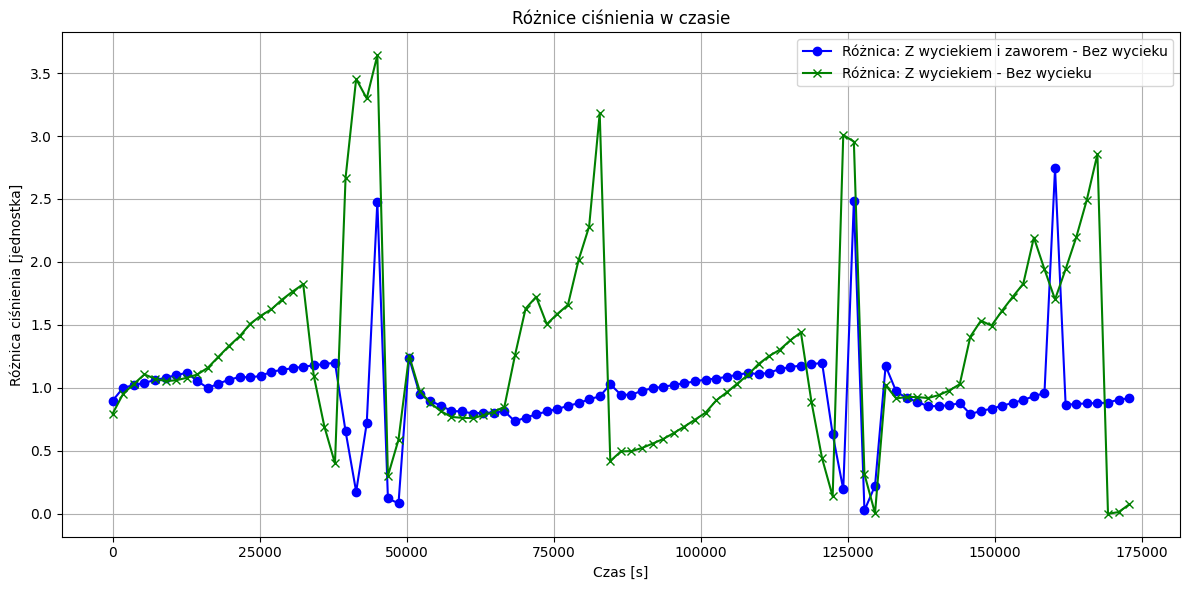

[210, 155, 124, 146, 278, 217, 143, 59]

Placing valve 9...
wskaznik_best: 10.226018025751614

pipe: 1
wskaznik: 10.226019930075307

pipe: 2
wskaznik: 10.226552044442405

pipe: 3
wskaznik: 16.363514679077845

pipe: 4
wskaznik: 16751843.884195972

pipe: 5
wskaznik: 11.130598603390807

pipe: 6
wskaznik: 11.126229074633457

pipe: 7
wskaznik: 11.117032115708161

pipe: 8
wskaznik: 10.335170000790898

pipe: 9
wskaznik: 10.802985536287087

pipe: 10
wskaznik: 10.584712076229414

pipe: 11
wskaznik: 10.761607237201558

pipe: 12
wskaznik: 10.551107671052968

pipe: 13
wskaznik: 34.176238746657546

pipe: 14
wskaznik: 34.68305957031997

pipe: 15
wskaznik: 17.729495684935284

pipe: 16
wskaznik: 19.034387609989658

pipe: 17
wskaznik: 11.257438873669987

pipe: 18
wskaznik: 1366619.4564486614

pipe: 19
wskaznik: 11.226691261128307

pipe: 20
wskaznik: 11.190883574162966

pipe: 21
wskaznik: 11.124748614902982

pipe: 22
wskaznik: 11.030159026851312

pipe: 23
wskaznik: 10.734614849703565

pipe: 24
wskaznik:

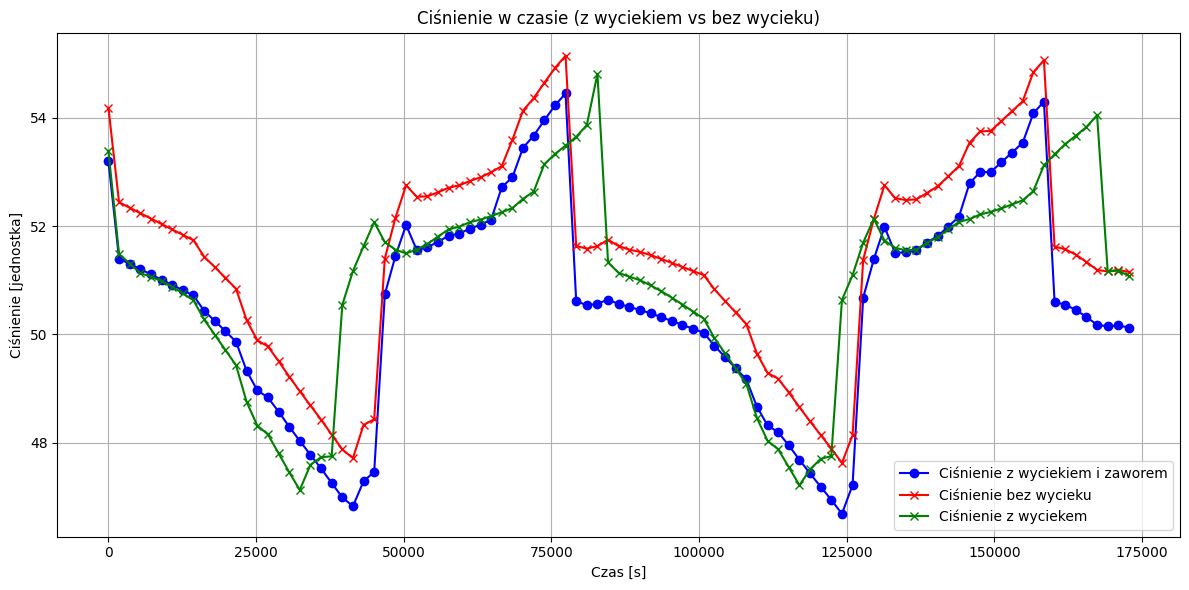

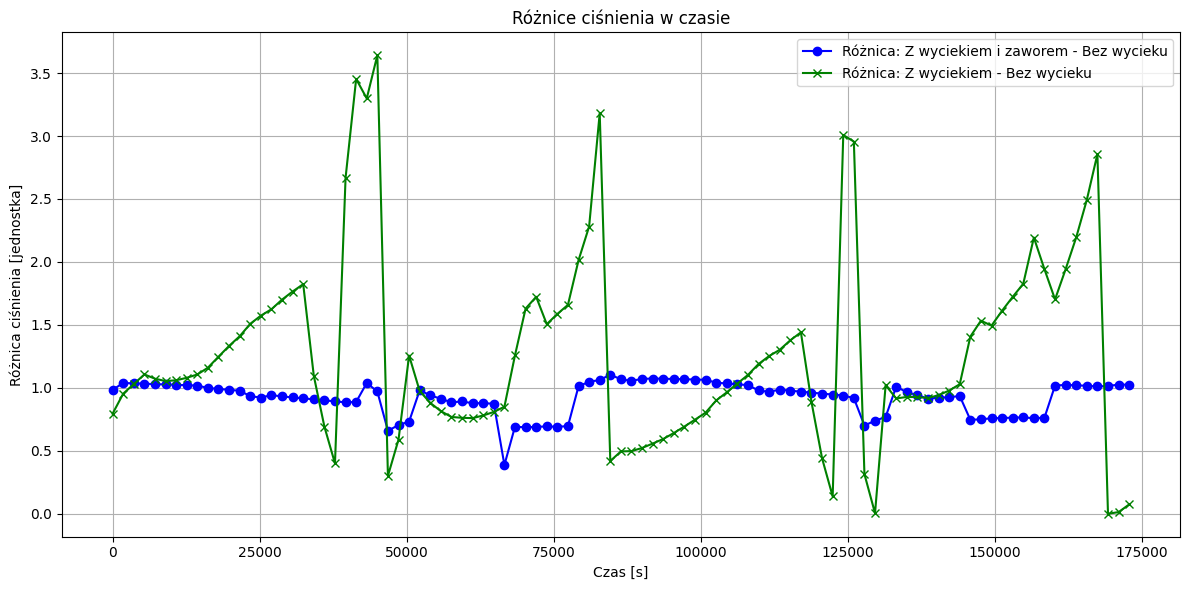

[210, 155, 124, 146, 278, 217, 143, 59, 171]

Placing valve 10...
wskaznik_best: 9.203487195156312

pipe: 1
wskaznik: 9.203523067906847

pipe: 2
wskaznik: 9.20352012845044

pipe: 3
wskaznik: 16.464440202948314

pipe: 4
wskaznik: 16757176.716737317

pipe: 5
wskaznik: 9.550552642809645

pipe: 6
wskaznik: 9.546995034308368

pipe: 7
wskaznik: 9.539747506667599

pipe: 8
wskaznik: 9.314919096434412

pipe: 9
wskaznik: 9.222636589450369

pipe: 10
wskaznik: 9.562322657507401

pipe: 11
wskaznik: 9.261245646874244

pipe: 12
wskaznik: 9.225328650958156

pipe: 13
wskaznik: 28.321279697325764

pipe: 14
wskaznik: 34.39984579635704

pipe: 15
wskaznik: 17.34939826287159

pipe: 16
wskaznik: 18.316557800556346

pipe: 17
wskaznik: 11.339792107757097

pipe: 18
wskaznik: 1366620.211726294

pipe: 19
wskaznik: 10.099587367812882

pipe: 20
wskaznik: 10.013725539843167

pipe: 21
wskaznik: 9.932800889989451

pipe: 22
wskaznik: 9.853678640603599

pipe: 23
wskaznik: 9.681817309363634

pipe: 24
wskaznik: 9.58344388

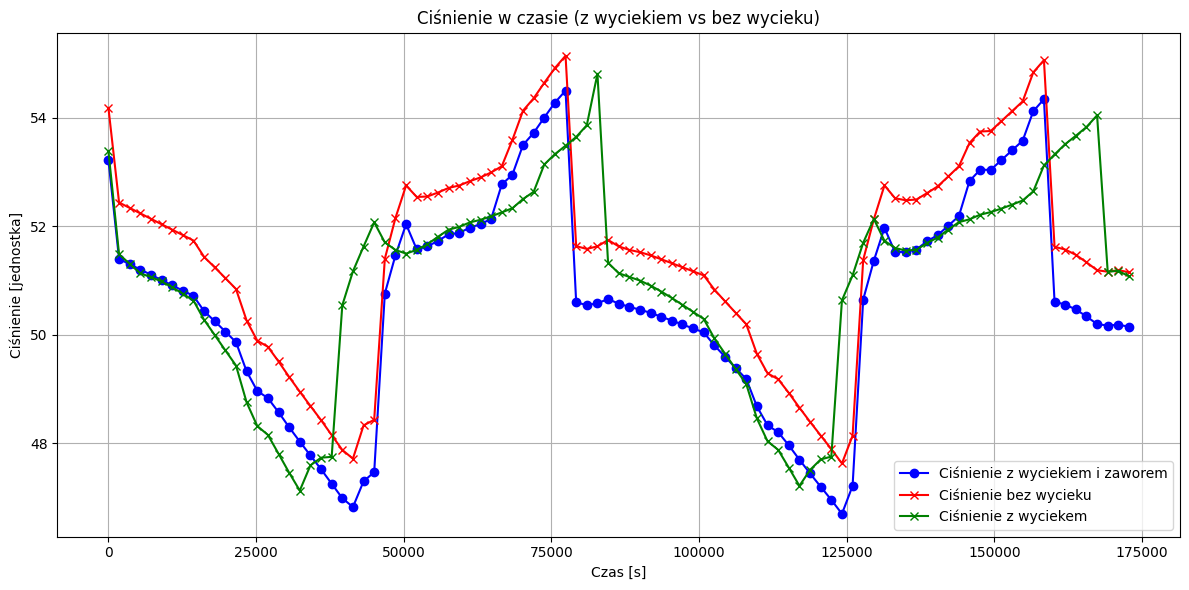

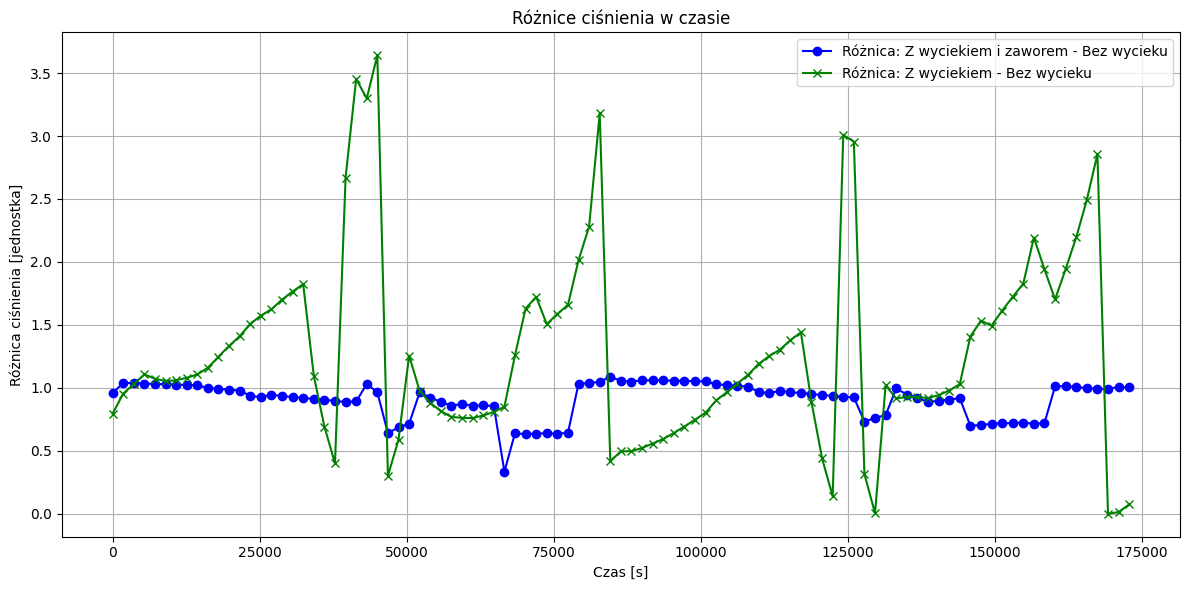

[210, 155, 124, 146, 278, 217, 143, 59, 171, 121]


In [14]:
leak_emit = 20
emit = d.getNodeEmitterCoeff()
emit = np.zeros_like(emit)

for leaknode in allleaknodes:
    leak_node_id = leaknode
    leak_node = d.getNodeIndex(leak_node_id)  # Get the node index
    emit[leak_node - 1] = leak_emit

d.setNodeEmitterCoeff(emit)

pressure_time_leak= DaneZSymulacji()
pressure_time_no_leak, pressure_time_leak = WspolnyCzas(pressure_time_no_leak, pressure_time_leak)
Wskaznik0 = OdlegloscEuklidesa(pressure_time_no_leak, pressure_time_leak)
print(f"wskaznik dla wycieku bez zaworów: {Wskaznik0}")
wskaznik_previous = Wskaznik0
BestPicks =[]


for valve_step in range(num_valves):
        print()
        print(f"Placing valve {valve_step + 1}...")

        Pick_me_pipe = 0
        wskaznik_best = wskaznik_previous
        print(f"wskaznik_best: {wskaznik_best}")


        for pipe in all_links:
                print()
                print(f"pipe: {pipe}")

                if pipe in restricted_pipes:
                      continue

                pipe_diameter = d.getLinkDiameter(pipe)
                d.setLinkDiameter(pipe, 1)
                pipe_diameterafter = d.getLinkDiameter(pipe)

                pressure_time_leak_pipe= DaneZSymulacji()
                pressure_time_no_leak, pressure_time_leak_pipe = WspolnyCzas(pressure_time_no_leak, pressure_time_leak_pipe)

                wskaznik = OdlegloscEuklidesa(pressure_time_no_leak, pressure_time_leak_pipe)
                print(f"wskaznik: {wskaznik}")

                if wskaznik <  wskaznik_best:
                        wskaznik_best = wskaznik
                        Pick_me_pipe = pipe
                        print(f"Pick_me_pipe: {Pick_me_pipe}")
                        pressure_time_leak_pipe_best = pressure_time_leak_pipe

                d.setLinkDiameter(pipe, pipe_diameter)
                pipe_diameterEND = d.getLinkDiameter(pipe)
        print(f"wskaznik_best:  {wskaznik_best}")
        if wskaznik_best >= wskaznik_previous:
                print("Wskaznik_best nie jest mniejszy niż wskaznik_previous, przerywam pętlę.")
                break

        wskaznik_previous = wskaznik_best
        print(f"Nowy wskaznik_previous: {wskaznik_previous}")

        restricted_pipes.append(Pick_me_pipe)
        BestPicks.append(Pick_me_pipe)
        d.setLinkDiameter(Pick_me_pipe, 1)
        print(f"Pick_me_pipe : {Pick_me_pipe}")
        print( d.getLinkDiameter(BestPicks))

        WykresZaworu(pressure_time_leak_pipe_best,pressure_time_no_leak,pressure_time_leak)
        pressure_time_leak_pipe_best, pressure_time_no_leak = WspolnyCzas(pressure_time_leak_pipe_best, pressure_time_no_leak)
        pressure_time_leak, pressure_time_no_leak = WspolnyCzas(pressure_time_leak, pressure_time_no_leak)
        WykresResiduum(pressure_time_leak_pipe_best,pressure_time_no_leak,pressure_time_leak)

        print(BestPicks)


[210, 155, 124, 146, 278, 217, 143, 59, 171]


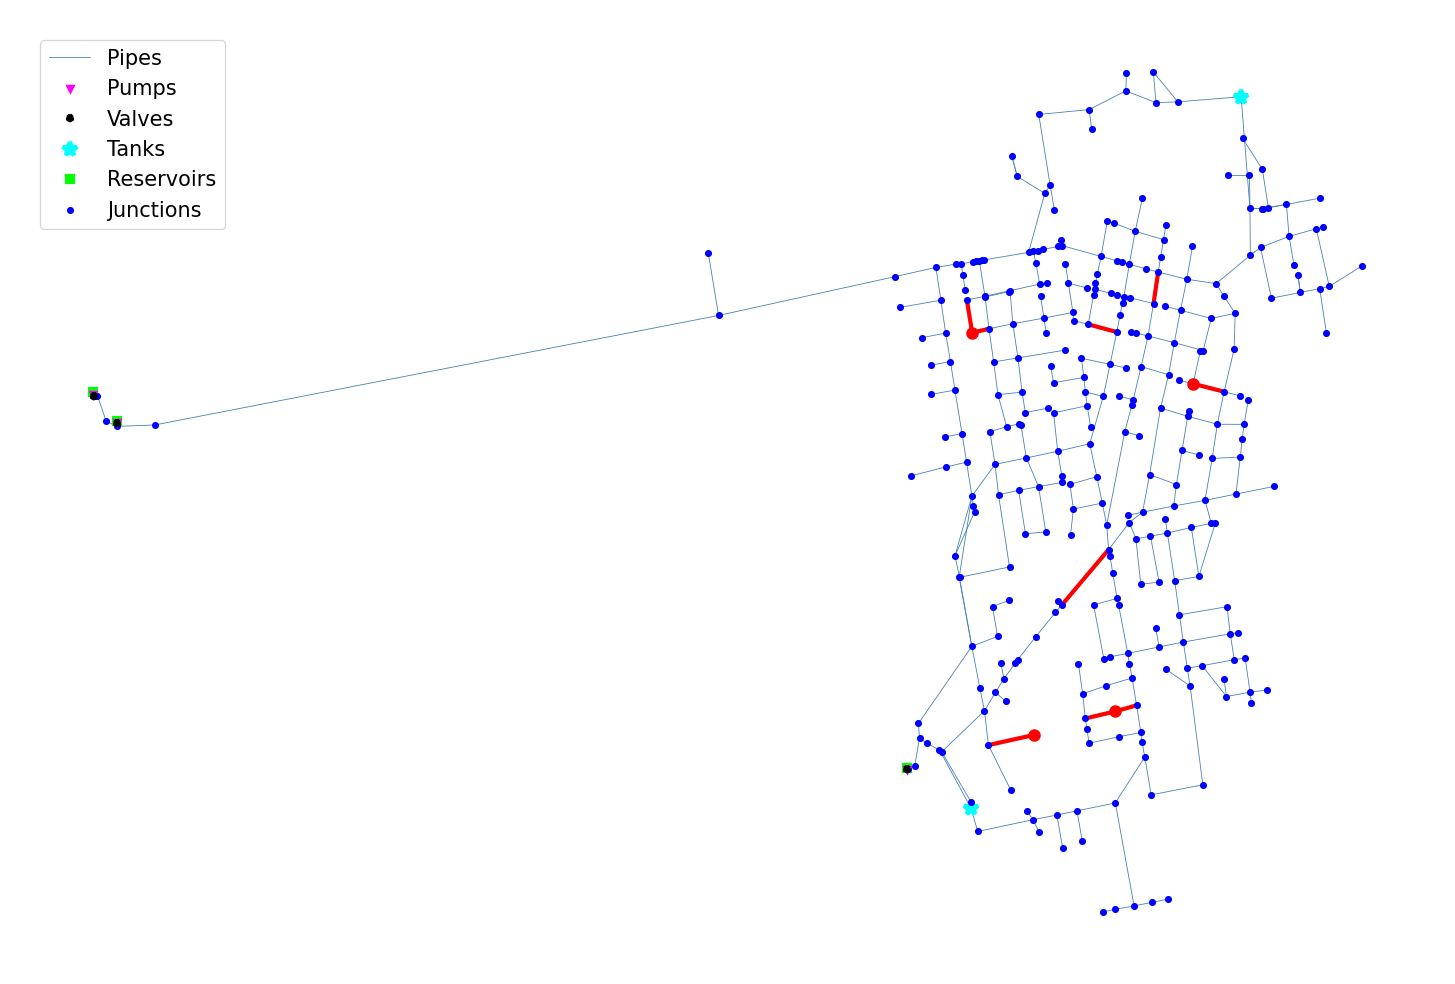

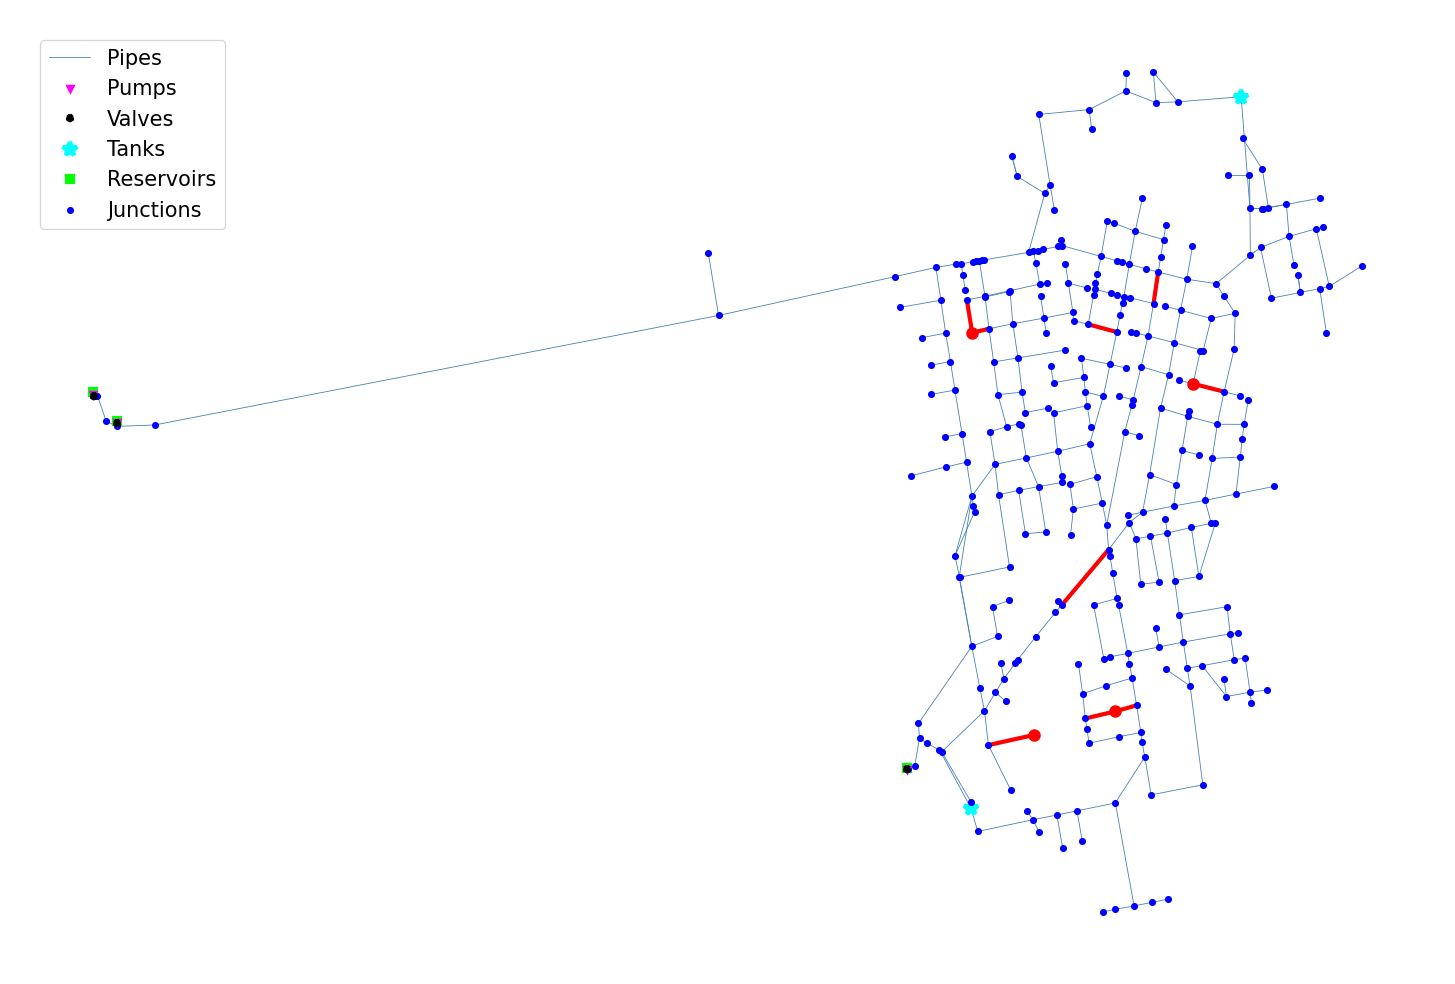

In [15]:
BestPicks = [210, 155, 124, 146, 278, 217, 143, 59, 171]
highlight_nodes = allleaknodes
highlight_links = BestPicks

print(BestPicks)
# Wykres sieci
d.plot(
    highlightnode=highlight_nodes,        # Węzły do wyróżnienia
    highlightlink=BestPicks,        # Rury do wyróżnienia
    fontsize=5,                           # Czcionka
    fig_size=[6, 4],                      # Rozmiar wykresu
    dpi=300,                              # Rozdzielczość
    highligthlink_linewidth=1,            # Grubość wyróżnionych rur
    highligthnode_linewidth=4,            # Grubość wyróżnionych węzłów
    colorbar_label="Values"               # Etykieta dla paska kolorów (opcjonalnie)
)
#[176, 124, 146, 155, 331, 142, 121, 216, 75, 217] zawory dla ['J211' , 'J155', 'J189', 'J56']
#[176, 124, 146, 155, 331, 142, 121, 216, 75, 217] dla ['J211' , 'J155', 'J189', 'J56']
#[210, 155, 124, 146, 278, 217, 143, 59, 171] dla ['J155' , 'J236', 'J189', 'J85']